# Modelling the Coronavirus outbreak in the Netherlands

## Background and model dynamics

The main purpose of the notebook is to:

- Understand better the dynamics of the Coronavirus outbreak -> what are key parameters?
- Understand the current development -> is the curve 'flattening'?
- Think about possible mitigation strategies

I will use the SEIR model to model the epidemic. This broadly used model is explained here: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

In short, it assumes that in a population there are four compartments of people during an infection:

- $S$ - Susceptible - not yet sick, but can become sick 
- $E$ - Exposed - people who have the virus, and are in the incubation period. They are not infectious or sick yet
- $I$ - Infected - people who are sick and infectious
- $R$ - Removed - people who either recovered or died from the virus

With $N$ being the total population, the following equation holds at all times: $N$ = $S$ + $E$ + $I$ + $R$



If we simplify by neglecting birth rates & deaths (other than from Corona), the model is governed by the following equations;


\begin{aligned}{\frac{dS}{dt}}&= -\beta {\frac {I}{N}}S,\\[8pt]{\frac {dE}{dt}}&=\beta {\frac {I}{N}}S- a E,\\[8pt]{\frac {dI}{dt}}&=aE-\gamma I,\\[8pt]{\frac {dR}{dt}}&=\gamma I .\end{aligned}

with key parameters;

\begin{aligned}{a^{-1} = T_{incubation}},\\
\\
{\beta^{-1} = T_{contacts}}, \\
\\
\gamma^{-1} = T_{recovery},\\
\\
R_0 = \frac{\beta}{\gamma}.\end{aligned}


where $T_{contacts}$ is the typical time between contacts, $T_{recovery}$ the typical time to recovery and $T_{incubation}$ the average incubation time.

## Expanding the model

In order to model the current epidemic properly, we have to expand the SEIR model with some buckets & parameters. The flow chart below depicts the dynamics of the model that we are using. This is loosely based on the following model:
https://www.medrxiv.org/content/10.1101/2020.03.18.20038612v1.full.pdf

In [314]:
%%html
<img src = "img/SEIR.png", width = 600, height = 400)>

The above schematic model is characterized by the following containers;

- $S$ - Susceptible - not yet sick, but can become sick 
- $E$ - Exposed - people who have the virus, and are in the incubation period. They are not infectious or sick yet 
- $I$ - Infected - consists of two separate containers; $I$ = $I_{A}$ + $I_{S}$
    - $I_{A}$ Asymptomatic (& mild) cases that will not end up at hospital, but will infect others
    - $I_{S}$ Symptomatic cases, people who are sick and infect others. After a period $\lambda$ these patients will be divided over two two containers:
        - $H_{R}$ Regular hospitalizations where people do not need IC, we assume they are in full quarantaine 
        - $H_{IC}$ IC hospitalizations, we assume they are in full quarantaine
- $R$ - Removed - We have now split this up in two containers, recovered and deaths, where $R$ = $R_{R}$ + $R_D$
    - $R_{R}$ People who have recovered from the illness, they can come from Asymptomatic, Hospitalized and IC cases
    - $R_{D}$ People who have died from the illness, they can come from hospitalized and IC cases

We now have the following additional key parameters:
- $a$ - the mean incubation time
- $\beta_1^{-1}$, $\beta_2^{-1}$ - respectively the time between contacts of 1) asymptomatic (& mild), and 2) (severe) symptomatic cases 
- $s$ - the hospitalization rate, the rate at which people become hospitalized
- $\lambda^{-1}$ - the mean time between development of symptoms & admittance to hospital
- $c$ - the IC rate, rate at which people are admitted to the IC
- $d_{1}$, $d_{2}$ - parameters relating to the mortality rates in 1) IC and in 2) hospital care
- $\delta_{1}$, $\delta_{2}$ - the mean times from respectively 1) IC admittance and 2) hospitalization to death
- $\gamma_{1}$, $\gamma_{2}$, $\gamma_{3}$ - the mean times from respectively 1) IC admittance, 2) hospitalization and 3) Asymptomatic cases to recovery

Additionally we have

- $R_{0,A} = \frac{\beta_1}{\gamma_3}$, the basic reproduction number for Asymptomatic population


- $R_{0,S} = \frac{\beta_2}{\lambda}$, the basic reproduction number for Symptomatic population



### Equations

The above model is governed by the following equations:

\begin{aligned}{\frac{dS}{dt}}&= -(\beta_1 I_A + \beta_2 I_S) {\frac {S}{N}},
\\[8pt]{\frac {dE}{dt}}&=(\beta_1 I_A + \beta_2 I_S) {\frac {S}{N}} - a E,
\\[8pt]{\frac {dI_A}{dt}}&=a(1-s)E-\gamma_3 I_A,
\\[8pt]{\frac {dI_S}{dt}}&=asE-\lambda I_S,
\\[8pt]{\frac {dH_R}{dt}}&=\lambda (1-c) I_S - ((1-d_2)\gamma_2 + d_2 \delta_2) H_R ,
\\[8pt]{\frac {dH_{IC}}{dt}}&=\lambda c I_S - ((1-d_1)\gamma_1 + d_1 \delta_1) H_{IC},
\\[8pt]{\frac {dR_R}{dt}}&=(1-d_1)\gamma_1 H_{IC} + (1-d_2)\gamma_2 H_R + \gamma_3 I_A
\\[8pt]{\frac {dR_D}{dt}}&=d_1 \delta_1 H_{IC} + d_2 \delta_2 H_R
\end{aligned}

### What we can learn from the data so far

The outbreak of Covid-19 on the Diamond Princess can be seen as a good proxy for the mortality rate of Covid-19 given that it was a closed population.

Taken from [3] and [4] we infer a mortality rate to be in the range of 0.5% - 1%, and the percentage of asymptomatic cases to be in the range of 40 - 50%, the percentage mild symptoms between 60-80%:

from [3]:
There have been 634 confirmed cases with 328 of these asymptomatic, correcting for age distribution, and time lag the outcome of the study is that the infection fatality rate (IFR) is estimated to be 1.2% (0.38% - 2.7%), and the case fatality rate (CFR) 2.3% (0.75% - 5.3%). Comparing deaths onboard with expected deaths based on naive CFR estimates using China data, we estimate IFR and CFR in China to be 0.5% (95% CI: 0.2–1.2%) and 1.1% (95% CI: 0.3–2.4%) respectively.

From [4]:
A total of 72,314 patient records—44,672 (61.8%) confirmed cases, 16,186 (22.4%) suspected cases, 10,567 (14.6%) clinically diagnosed cases (Hubei Province only), and 889 asymptomatic cases (1.2%)—contributed data for the analysis. Among confirmed cases, most were aged 30–79 years (86.6%), diagnosed in Hubei (74.7%), and considered mild (80.9%). A total of 1,023 deaths occurred among confirmed cases for an overall case fatality rate of 2.3%. The COVID-19 spread outward from Hubei Province sometime after December 2019, and by February 11, 2020, 1,386 counties across all 31 provinces were affected. The epidemic curve of onset of symptoms peaked around January 23–26, then began to decline leading up to February 11. A total of 1,716 health workers have become infected and 5 have died (0.3%).

### Qualitative Assumptions

We have a number of assumptions in this model:
1. We assume that people admitted to the hospital & IC will immediately end up at those departments, so no movement between departments
2. The incubation time between asymptomatic and symptomatic cases is assumed to be the same
3. We have used asymptomatic as a name to depict cases that do not end up at the hospital, this therefore also includes mild symptomatic cases
4. We are assuming that mortality rate in the asymptotic and mild cases is zero
5. Birth rate and deaths (other than corona) have been put to zero

# Quantitative assumptions

There are a number of quantitative assumptions with regards to the values for the different parameters:

<table>
  <thead>
    <tr>
      <th>Parameter</th>
      <th>Previous study</th>
      <th>Reference</th>  
      <th>Used here</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>$a$</td>
      <td>4.1 - 7.0 (5.2)</td>
      <td>[1]</td>
      <td>5.2</td>
    </tr>
    <tr>
      <td>$\beta_1$</td>
      <td> </td>
      <td> </td>
      <td>To be fitted</td> 
    </tr>
    <tr>
      <td>$\beta_2$</td>
      <td> </td>
        <td> </td>
       <td>To be fitted</td>
    </tr>
    <tr>
      <td>$s$</td>
      <td>0.05 - 0.15</td>
        <td>[4]</td>
      <td>0.075</td>
    </tr>
    <tr>
      <td>$\lambda$</td>
      <td>4.3 - 7.5 (5.8)</td>
        <td>[1]</td>
      <td>5.8</td>
    </tr>
    <tr>
      <td>$c$</td>
      <td></td>
        <td>estimate</td>
      <td>0.4</td>
    </tr>
    <tr>
      <td>$d_1$</td>
      <td>t.b.d.</td>
        <td>[3],[4]</td>
      <td>t.b.d.</td>
    </tr>
    <tr>
      <td>$d_2$</td>
      <td>t.b.d.</td>
        <td>[3],[4]</td>
      <td>t.b.d.</td>
    </tr>
    <tr>
      <td>$\delta_1$</td>
      <td> </td>
        <td>estimate</td>
      <td>7</td>
    </tr>
    <tr>
      <td>$\delta_2$</td>
      <td> </td>
        <td>estimate</td>
      <td>7</td>
    </tr>
    <tr>
      <td>$\gamma_1$</td>
      <td> </td>
        <td>estimate</td>
      <td>10</td>
    </tr>
    <tr>
      <td>$\gamma_2$</td>
      <td> </td>
        <td>estimate</td>
      <td>15</td>
    </tr>
    <tr>
      <td>$\gamma_3$</td>
      <td>4</td>
        <td>[1]</td>
      <td>14</td>
        </tr>
     <tr>
      <td>$R_0$</td>
      <td>3.58 / 1.5 - 3.5 (2.6), </td>
       <td>[1] / [2],</td>
      <td>To be fitted</td>
    </tr>
  </tbody>
</table>

### Relations

The correlation between mortality rates in IC ($m_{IC}$) and hospital ($m_{H}$) can be given by:

$d_1 = \frac{\gamma_1}{\gamma_1 - \delta_1 +\frac{\delta_1}{m_{IC}}}$,

$d_2 = \frac{\gamma_2}{\gamma_2 - \delta_2 +\frac{\delta_2}{m_{H}}}$,



### Context Netherlands

Patient 0 in the Netherlands has visited Italy in February 18th. From 25th onwards he felt unwell. 

A test in a hospital showed that out of 1353 employees, 83 had corona, and 7 had symptoms already between 19th of feb and 25th of feb.

The government took the following measures:

1. 6 maart: Speciale maatregelen voor Noord-Brabant
2. 9 maart: Nederland stopt met handen schudden
3. 12 maart: Evenementen afgelast en oproep tot thuiswerken
4. 15 maart: Scholen gaan sluiten, ook deel horeca dicht
5. 16 maart: Speech Mark Rutte, oproep tot thuisblijven
6. 20 maart: Testbeleid wordt opnieuw aangescherpt
7. 22 maart: NL-Alert over houden van afstand
8. 23 maart: Extra maatregelen tegen coronavirus -> groepsvorming verboden
9. 26 maart: ingaan regelen groepsvorming

From this we distill 3 significant periods during which R_0 can be varied:
1. up until 15 March -> $R_0$ 29 days
2. up until 23 March -> $R_1$ 8 days
3. After 23 March. -> $R_2$ 6 days

Where we assume $R_0 > R_1 > R_2$

In [1]:
#the code in this notebook is based on the work done in https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# First we will import some packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#We create a function to model the above differential equations, with: 
#y a vector of S, E, I_A, I_S, H_R, H_IC, R_R and R_D
#N the population size, 
#a the average incubation period, 
#beta1 the time between contacts for asymptotic cases, and beta2 for symptomatic cases, 
#c the IC rate for people with severe conditions, 
#d1 mortality rate for IC admitted patients and d2 for hospitalized patients, 
#delta1 the mean time to death from IC admittance and delta 2 from hospitalization
#gamma1 the recovery time from IC admittance, gamma2 from hospitalization, gamma3 from asymptotic cases
def deriv(y, t, N, p, beta1, beta2):
    a, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3 = p
    S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T = y
    dSdt = -(beta1 * I_A + beta2 * I_S) * S / N
    dEdt = (beta1 * I_A + beta2 * I_S) * S / N - a * E
    dI_Adt = a * (1-s) * E - gamma3 * I_A
    dI_Sdt = a * s * E - lam * I_S
    dH_Rdt = lam * (1-c) * I_S - ((1-d2) * gamma2 + d2 * delta2)* H_R
    dH_ICdt = lam * c * I_S - ((1-d1)* gamma1 + d1 * delta1)* H_IC
    dR_Rdt = (1-d1)* gamma1*H_IC + (1-d2) * gamma2 * H_R + gamma3 * I_A
    dR_Ddt = d1 * delta1 * H_IC + d2 * delta2 * H_R
    dTdt = dSdt + dEdt + dI_Adt + dI_Sdt + dH_Rdt + dH_ICdt + dR_Rdt + dR_Ddt
    return dSdt, dEdt, dI_Adt, dI_Sdt, dH_Rdt, dH_ICdt, dR_Rdt, dR_Ddt, dTdt

#A function to simulate an integration over time, with S0, E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0, T0 the starting conditions of the function, 
#t_n the number of steps (days), and N the population size
#def simulation(S0, E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0, T0,N, a, beta1, beta2, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3,t_n):
def simulation(y,p, beta1, beta2, t_n):
    t = np.linspace(0, t_n-1, t_n)
    y0 = y[0:9]
    a, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3 = p
    ret = odeint(deriv, y0, t, args=(y[-1], p,beta1, beta2))
    S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T = ret.T
    y_sim = S, E, I_A, I_S, H_R, H_IC, R_R, R_D, T, t
    return y_sim

# a function to plot the simulation
def plot(y_sim,y_max):
    S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T,t = y_sim
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S, 'orange', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E, 'yellow', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I_A, 'blue', alpha=0.5, lw=2, label='Infected Asymptotic')
    ax.plot(t, I_S, 'pink', alpha=0.5, lw=2, label='Symptomatic')
    ax.plot(t, H_R, 'red', alpha=0.5, lw=2, label='Hospitalized')
    ax.plot(t, H_IC, 'purple', alpha=0.5, lw=2, label='IC')
    ax.plot(t, R_R, 'green', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, R_D, 'black', alpha=0.5, lw=2, label='Deaths')
    ax.plot(t, T, 'black', alpha=0.5, lw=2, label='Total')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,N/1000+50)
    ax.set_ylim(0,y_max*1000)
    #ax.set_xlim(0,30)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    leg = ax.legend()
    leg.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
#a trick to get the legend in the right place
    plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
    xOffset = 0.5
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
    plt.show()

In [156]:
# General conditions:
a, s, lam, c = 1/5.2, 0.80, 1/5.8, 0.30
delta1, delta2 = 1/2, 1/2
gamma1, gamma2, gamma3 = 1/21, 1/15.2, 1/8
m_IC = 0.40
m_H = 0.05

d1 = gamma1/(gamma1-delta1+delta1/m_IC)
d2 = gamma2/(gamma2-delta2+delta2/m_H)

p_general = a, s, lam, c, d1, d2, delta1, delta2, gamma1, gamma2, gamma3

In [157]:
# Starting conditions Netherlands
N_nl = 17000000
E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0 = 10, 10, 1, 0, 0, 0, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0 = N_nl - E0 - I_A0 - I_S0 - R_R0 - R_D0 # Everyone else, S0, is susceptible to infection initially.
T0 = 17000000
y_nl = S0, E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0,T0

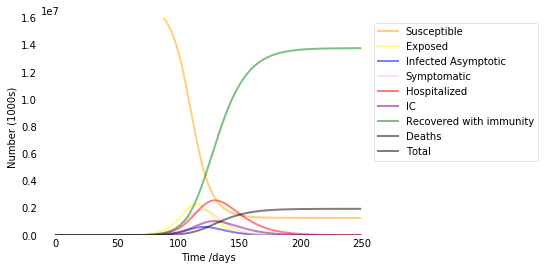

In [158]:
# making a first simulation
y_sim = simulation(y_nl,p_general,0.3, 0.5,250)
plot(y_sim,16000)

In [159]:
S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T,t = y_sim

In [160]:
sum(H_IC)*(d1*delta1+(1-d1)*gamma1), sum(H_R)*gamma2, R_R[-1], R_D[-1]

(3772970.69167582, 8419960.4682861, 13770585.312992763, 1949276.1870579207)

In [161]:
sum(H_R)*gamma2/R_R[-1], sum(H_IC)*gamma2/R_R[-1], R_D[-1]/(R_R[-1]+R_D[-1])

(0.6114453581244463, 0.24154176857545612, 0.1240008499471599)

In [171]:
# Measured infections in the Netherlands, from 1 feb
dates = ['18-feb','19-feb','20-feb','21-feb', '22-feb', '23-feb','24-feb','25-feb','26-feb','27-feb','28-feb','29-feb','1-mar','2-mar','3-mar','4-mar','5-mar','6-mar','7-mar','8-mar','9-mar','10-mar','11-mar','12-mar','13-mar','14-mar','15-mar','16-mar','17-mar','18-mar','19-mar','20-mar','21-mar','22-mar','23-mar','24-mar','25-mar','26-mar','27-mar','28-mar','29-mar','30-mar','31-mar','1-apr','2-apr']
I_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,20,30,40,80,130,190,270,320,380,500,610,800,960,1140,1410,1710,2051,2460,2994,3631,4204,4749,5560,6412,7431,8603,9762, 10866,11750,12595])
H_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,124,142,181,271,350,413,537,700,809,1051,1295,1836,2151, 2500, 2954, 3483, 3990, 4712])
IC_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,130,175,210,281,354,405,487,550,645,761,890,975,1005,1050,1030])
D_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,12,20,24,43,58,76,106,136,179,213,276,356,434,546,639,771,874, 1039, 1173, 1339, 1487, 1651, 1766])
IC_capacity_NL = np.ones(I_measured_NL.size)*2000

In [93]:
H_measured_NL[27], dates[27]

(124, '16-mar')

In [172]:
IC_measured_NL.size, I_measured_NL[19:32]
D_measured_NL.size

50

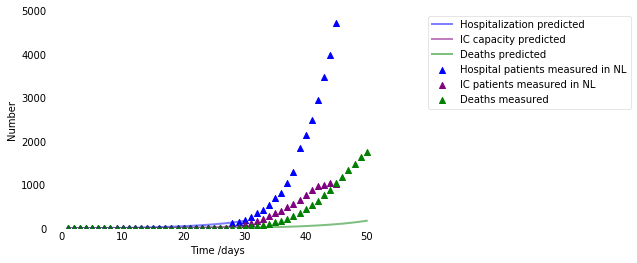

In [173]:
#t = np.linspace(1, I_measured_NL.size,I_measured_NL.size)
t1 = np.linspace(1, 50,50)
t2 = np.linspace(1, 30,30)
t3 = np.linspace(1, 45,45)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
#three sets of two plots
#ax.plot(t, I_measured_NL, 'y', alpha=0.5, lw=2, label='Infected patients measured in NL')
#ax.plot(t, E[0:27]+I_A[0:27]+I_S[0:27]+H_R[0:27]+H_IC[0:27], 'r', alpha=0.5, lw=2, label='Predicted infected people in NL')

ax.scatter(t3, H_measured_NL, color ='blue', marker = "^",label='Hospital patients measured in NL')
ax.plot(t2, H_R[0:30]+H_IC[0:30], 'blue', alpha=0.5, lw=2, label='Hospitalization predicted')

ax.scatter(t3, IC_measured_NL, color = 'purple',marker = "^", label='IC patients measured in NL')
ax.plot(t2, H_IC[0:30], 'purple', alpha=0.5, lw=2, label='IC capacity predicted')

ax.scatter(t1, D_measured_NL, color ='green', marker = "^",label='Deaths measured')
ax.plot(t1, R_D[0:50], 'green', alpha=0.5, lw=2, label='Deaths predicted')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,5000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
leg = ax.legend()
leg.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
#a trick to get the legend in the right place
plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.75
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
plt.show()


In [879]:
H_IC[0:27] - IC_measured_NL

array([ 0.00000000e+00,  7.99751772e-02,  2.08824265e-01,  3.83023576e-01,
        6.07056772e-01,  8.91775416e-01,  1.25404229e+00,  1.71727755e+00,
        2.31274436e+00,  3.08154991e+00,  4.07743837e+00,  5.37053663e+00,
        7.05229769e+00,  9.24198076e+00,  1.20951210e+01, -7.41854133e+01,
       -1.09334996e+02, -1.48008431e+02, -1.74755421e+02, -2.34988604e+02,
       -2.93941894e+02, -3.26616244e+02, -3.84709048e+02, -4.16522353e+02,
       -4.70843628e+02, -5.33791124e+02, -5.93613691e+02])

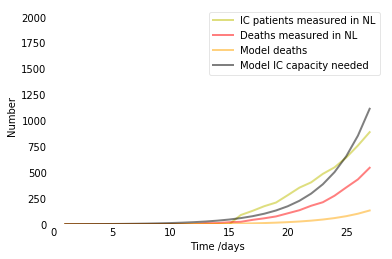

In [880]:
#t = np.linspace(1, I_measured_NL.size,I_measured_NL.size)
t = np.linspace(1, 27,27)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
#ax.plot(t, I_measured_NL, 'b', alpha=0.5, lw=2, label='Infections measured in NL')
#ax.plot(t, H_measured_NL, 'g', alpha=0.5, lw=2, label='Hospital patients measured in NL')
ax.plot(t, IC_measured_NL, 'y', alpha=0.5, lw=2, label='IC patients measured in NL')
ax.plot(t, D_measured_NL, 'r', alpha=0.5, lw=2, label='Deaths measured in NL')
ax.plot(t, R_D[5:32], 'orange', alpha=0.5, lw=2, label='Model deaths')
ax.plot(t, H_IC[5:32], 'black', alpha=0.5, lw=2, label='Model IC capacity needed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,2100)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Germany case study

The mortality rate in Germany has been much lower than elsewhere. Most likely this is due to their extensive testing regime, through which they seem to be much closer to the true mortality rate of the virus. We want to study if we can find out more about the parameters of the virus which are inherent to the virus itself, and use this for fitting our model in the Dutch situation.

In [354]:
#Germany numbers from March 1st 2020 onwards:
I_measured_GER = np.array([130,165,203,262,545,670,800,1040,1224,1565,1966,2745,3675,4599,5813,7272,9367,12327,15320,19848,22364,24873,29056,32991,37323,43938])
H_measured_GER = np.array([])
IC_measured_GER = np.array([])
D_measured_GER = np.array([0,0,0,0,0,0,0,0,2,2,3,6,8,9,13,17,26,28,44,68,84,94,123,159,206,267])
IC_capacity_GER = np.ones(I_measured_GER.size)*2000

In [885]:
### German situation
N_GER = 87790000 #pop size
T0G = 87790000
E0G, I_A0G, I_S0G,H_R0G,H_IC0G,R_R0G,R_D0G = 500, 500, 10, 0, 0, 0, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0G = N_GER - E0G - I_A0G - I_S0G - R_R0G - R_D0G # Everyone else, S0, is susceptible to infection initially.

y_ger = S0G, E0G, I_A0G, I_S0G,H_R0G,H_IC0G,R_R0G,R_D0G,T0G

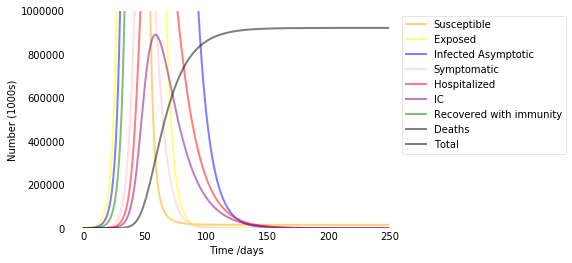

In [928]:
# Running the Germany simulation
y_ger_sim = simulation(y_ger, p_general,beta1, beta2,250)
plot(y_ger_sim,1000)

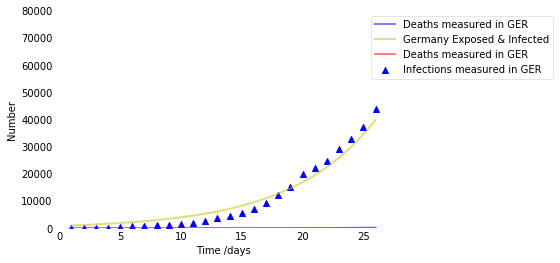

In [881]:
#plotting the real Germany situation
t = np.linspace(1, I_measured_GER.size,I_measured_GER.size)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.scatter(t, I_measured_GER, color ="blue",marker = "^", label='Infections measured in GER')
ax.plot(t, D_measured_GER, 'blue', alpha=0.5, lw=2, label='Deaths measured in GER')
ax.plot(t, EG[0:26]+I_SG[0:26]+I_AG[0:26]+H_RG[0:26]+H_ICG[0:26], 'y', alpha=0.5, lw=2, label='Germany Exposed & Infected')
ax.plot(t, R_DG[0:26], 'r', alpha=0.5, lw=2, label='Deaths measured in GER')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,80000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
leg = ax.legend()
leg.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
# a trick to get the legend in the right place
plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.5
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
plt.show()

In [383]:
R_DG[0:50]

array([0.00000000e+00, 3.39930333e-03, 1.67593649e-02, 4.53398057e-02,
       9.48257432e-02, 1.71189155e-01, 2.80689754e-01, 4.29953829e-01,
       6.26098515e-01, 8.76885230e-01, 1.19089513e+00, 1.57772470e+00,
       2.04820248e+00, 2.61463009e+00, 3.29105159e+00, 4.09355662e+00,
       5.04062321e+00, 6.15350760e+00, 7.45668878e+00, 8.97837715e+00,
       1.07510976e+01, 1.28123588e+01, 1.52054222e+01, 1.79801875e+01,
       2.11942103e+01, 2.49138747e+01, 2.92157426e+01, 3.41881084e+01,
       3.99327887e+01, 4.65671837e+01, 5.42266500e+01, 6.30672337e+01,
       7.32688155e+01, 8.50387304e+01, 9.86159321e+01, 1.14275783e+02,
       1.32335560e+02, 1.53160786e+02, 1.77172492e+02, 2.04855568e+02,
       2.36768329e+02, 2.73553486e+02, 3.15950707e+02, 3.64810984e+02,
       4.21113052e+02, 4.85982108e+02, 5.60711137e+02, 6.46785150e+02,
       7.45908662e+02, 8.60036774e+02])

In [384]:
D_measured_GER

array([  0,   0,   0,   0,   0,   0,   0,   0,   2,   2,   3,   6,   8,
         9,  13,  17,  26,  28,  44,  68,  84,  94, 123, 159, 206, 267])

**Reference**

[1]. T. Chen, J. Rui, Q. Wang, Z. Zhao, J.-A. Cui, and
L. Yin, “A mathematical model for simulating the
phase-based transmissibility of a novel
coronavirus,” Infect. Dis. Poverty, vol. 9, no. 24,
p. 2020.01.19.911669, 2020.

[2]. N. Imai et al., “Report 3: Transmissibility of 2019-
nCoV,” Imp. Coll. London, pp. 2–6, 2020.

[3] T.Russell1, J.Hellewell1, C.Jarvis, K. Van Zandvoort,S.Abbott, R.Ratnayake,S.Flasche1, R.M. Eggo1, W.J Edmunds, A.J.Kucharski, "Estimating the infection and case fatality ratio for COVID-19 using age-adjusted data from the outbreak on the Diamond Princess cruise ship"

[4] The Novel Coronavirus Pneumonia Emergency Response Epidemiology Team. The Epidemiological Characteristics of an Outbreak of 2019 Novel Coronavirus Diseases (COVID-19) — China, 2020[J]. China CDC Weekly, 2020, 2(8): 113-122.

In [94]:
def squared_loss(f,g):
    z = f - g
    R_squared = sum(np.square(z))
    return R_squared

#def Solver_for_R(y,p,beta1_0,beta2_0,beta1_steps,beta2_steps,t):
def Solver_for_R(y,p,beta1_0,beta1_steps,t):
    optimal = 10**20
    Total = 0
    for i in range(beta1_steps):
        beta1 = beta1_0 + 0.001*i
        beta2 = beta1_0 + 0.001*i
        #for j in range(beta1_steps):
            #beta2 = beta2_0 + 0.01*j
        y_sim = simulation(y,p,beta1,beta2,100)
        S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T,t = y_sim
        R_2_hospitalized = squared_loss(H_R[27:41]+H_IC[27:41],H_measured_NL[27:41])
        #R_2_IC = squared_loss(H_IC[28:41],IC_measured_NL[28:41])
        R_2_deaths = squared_loss(R_D[27:41],D_measured_NL[27:41])
        Total = R_2_deaths + R_2_hospitalized #+ R_2_IC  + R_2_hospitalized
        print(Total)
        if Total < optimal:
            optimal = Total
            y_optimal = beta1, beta2
    return optimal, y_optimal

def Solver_for_R2(y,p,beta1_0,beta2_0,beta1_steps,beta2_steps,t):
    optimal = 10**20
    Total = 0
    for i in range(beta1_steps):
        beta1 = beta1_0 + 0.01*i
        for j in range(beta2_steps):
            beta2 = beta2_0 + 0.01*j
            y_sim = simulation(y,p,beta1,beta2,100)
            S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T,t = y_sim
            R_2_hospitalized = squared_loss(H_R[1:14]+H_IC[1:14],H_measured_NL[32:45])
            #R_2_IC = squared_loss(H_IC[1:10],IC_measured_NL[32:45])
            R_2_deaths = squared_loss(R_D[1:14],D_measured_NL[32:45])
            Total = R_2_deaths + R_2_hospitalized #+ R_2_IC  + R_2_hospitalized
            print(Total)
            if Total < optimal:
                optimal = Total
                y_optimal = beta1, beta2
    return optimal, y_optimal

def Solver_for_R3(y,p,beta1_0,beta2_0,beta1_steps,beta2_steps,t):
    optimal = 10**20
    Total = 0
    for i in range(beta1_steps):
        beta1 = beta1_0 + 0.04*i
        for j in range(beta2_steps):
            beta2 = beta2_0 + 0.04*j
            y_sim = simulation(y,p,beta1,beta2,100)
            S, E, I_A, I_S, H_R, H_IC, R_R, R_D,T,t = y_sim
            #R_2_hospitalized = squared_loss(H_R[1:8]+H_IC[1:8],H_measured_NL[40:47])
            #R_2_IC = squared_loss(H_IC[1:8],IC_measured_NL[40:47])
            R_2_deaths = squared_loss(R_D[1:8],D_measured_NL[40:47])
            Total = R_2_deaths #+ R_2_IC  + R_2_hospitalized
            print(Total)
            if Total < optimal:
                optimal = Total
                y_optimal = beta1, beta2
    return optimal, y_optimal

In [111]:
# Starting conditions Netherlands
N_nl = 17000000
E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0 = 10, 1, 1,0, 0, 0, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0 = N_nl - E0 - I_A0 - I_S0 - R_R0 - R_D0 # Everyone else, S0, is susceptible to infection initially.
T0 = 17000000
y_nl1 = S0, E0, I_A0, I_S0,H_R0,H_IC0,R_R0,R_D0,T0

In [112]:
Solver_for_R(y_nl1,p_general,0,1000,100)

19656159.7488532
19655646.91193154
19655127.71501065
19654602.081274554
19654069.933272596
19653531.19249684
19652985.779648002
19652433.61455929
19651874.6161869
19651308.702602435
19650735.79098437
19650155.797609173
19649568.63784248
19648974.22613041
19648372.475990236
19647763.300001692
19647146.609797817
19646522.3160558
19645890.328487743
19645250.555831265
19644602.90583766
19643947.28525988
19643283.59987745
19642611.75442367
19641931.652621772
19641243.197164558
19640546.2896983
19639840.830822468
19639126.720073
19638403.855913837
19637672.135726877
19636931.455801573
19636181.711324617
19635422.796369404
19634654.603885595
19633877.0256884
19633089.95244791
19632293.273678266
19631486.877726737
19630670.651762772
19629844.481766876
19629008.252519473
19628161.84758964
19627305.149323743
19626438.038848054
19625560.39603021
19624672.099436346
19623773.02643371
19622863.053083587
19621942.054151226
19621009.903248537
19620066.472220816
19619111.63203325
19618145.252161026
196

13025631.639227629
12968346.498699598
12910679.572489152
12852630.155702235
12794197.58305028
12735381.229931261
12676180.514510982
12616594.89647584
12556623.879280297
12496267.162993992
12435524.042107578
12374394.310097212
12312877.658940941
12250973.830660095
12188682.618592685
12126003.868763555
12062937.481020387
11999483.41050709
11935641.669040387
11871412.326483462
11806795.51216678
11741791.41633968
11676400.291644694
11610622.454619896
11544458.287228722
11477908.238418987
11410972.825709758
11343652.636806857
11275948.331248866
11207860.64208319
11139390.377570877
11070538.422918484
11001305.725975443
10931693.366694218
10861702.45264099
10791334.194860877
10720589.890473727
10649470.92464683
10577978.772615883
10506115.00164585
10433881.273069132
10361279.344275218
10288311.070942575
10214978.409199215
10141283.417776218
10067228.26023446
9992815.207232455
9918046.638834432
9842925.046859844
9767453.037269365
9691633.33260185
9615468.774451233
9538962.32132327
9462117.0699

2143616654.2432175
2179291199.645564
2215518308.654
2252306079.5572033
2289662724.020914
2327596568.603727
2366116056.293434
2405229747.8937197
2444946323.843435
2485274586.081871
2526223458.973436
2567801991.131647
2610019357.849694
2652884861.821435
2696407935.179953
2740598141.2064023
2785465176.096111
2831018870.7165384
2877269192.395047
2924226246.717944
2971900279.3675776
3020301677.9756536
3069440974.004385
3119328844.658111
3169976114.795643
3221393724.8011317
3273592869.179758
3326584793.1525297
3380380931.8535852
3434992877.862915
3490432384.068234
3546711364.8517094
3603841898.5385566
3661836229.5481086
3720706770.572217
3780466104.782105
3841126988.0608306
3902702351.257986
3965205302.480843
4028649129.4099092
4093047301.648851
4158413473.0961246
4224761484.3391976
4292105365.092146
4360459336.656479
4429837814.416054
4500255410.356766
4571726935.620248
4644267403.089709
4717892030.009106


(605422.3708957226, (0.646, 0.646))

In [162]:
y_sim1 = simulation(y_nl1,p_general,0.646,0.646,100)
S1, E1, I_A1, I_S1, H_R1, H_IC1, R_R1, R_D1,T,t = y_sim1

In [114]:
# Starting conditions time box 2: 8 days Netherlands
N_nl = 17000000
St, Et, I_At, I_St,H_Rt,H_ICt,R_Rt,R_Dt = S1[32],E1[32], I_A1[32], I_S1[32],H_R1[32],H_IC1[32],R_R1[32],R_D1[32] # Initial number of exposed, infected and recovered individuals, I0 and R0.
T0 = 17000000
y_nl2 = St, Et, I_At, I_St,H_Rt,H_ICt,R_Rt,R_Dt,T0

In [16]:
H_R1[32] + H_IC1[32]

1818.0653227825082

In [25]:
Solver_for_R2(y_nl2,p_general,0,0,150,150,100)

27930612.77968864
27531377.37953449
27129572.603611927
26725269.01281483
26318540.992799982
25909466.83922598
25498128.93383083
25084613.835733835
24669012.41945116
24251420.00801822
23831936.509045064
23410666.553785875
22987719.638276502
22563210.283281397
22137258.162155464
21709988.278416455
21281531.107491136
20852022.767243735
20421605.182745446
19990426.256521143
19558640.044208534
19126406.934034742
18693893.88196823
18261274.393102437
17828729.028942943
17396445.393537495
16964618.390303813
16533450.429475145
16103151.64397961
15673940.096934628
15246042.020997036
14819692.038441109
14395133.396769134
13972618.209747918
13552407.703645809
13134772.46958965
12719992.72194267
12308358.562683936
11900170.252513397
11495738.490108486
11095384.679064935
10699441.27160611
10308252.008604271
9922172.217410177
9541569.190678718
9166822.454200797
8798324.107682751
8436479.159419546
8081705.869486818
7734436.10061376
7395115.677335395
7064204.770826492
6742178.200988078
6429525.89165389

20749652.487277284
20319541.155313246
19888700.974648137
19457286.99344836
19025460.61658999
18593389.841674324
18161249.240694232
17729220.467823923
17297492.24625423
16866260.62537165
16435729.188981082
16006109.272051431
15577620.167255124
15150489.367835455
14724952.785706619
14301254.988831442
13879649.442701578
13460398.757366534
13043774.940371512
12630059.65582819
12219544.48937256
11812531.220597621
11409332.102195073
11010270.127539923
10615679.397243416
10225905.256868986
9841304.797893561
9462247.036210291
9089113.2812028
8722297.45736041
8362206.439554108
8009260.397468422
7663893.147115512
7326552.510973027
6997700.6985205915
6677814.635582566
6367386.365927795
6066923.630229574
5776949.929395186
5498005.163599118
5230646.027271479
4975446.415660813
4732997.871435346
4503910.07716763
4288811.143684738
4088348.372347108
3903188.490225452
3734018.6843748605
3581545.643230035
3446498.3322076527
3329626.5277087674
3231702.1376926145
3153520.0438945144
3095898.2529301876
30596

13786974.401402667
13368692.295660805
12953088.850330658
12540447.183219315
12131060.367635813
11725231.706160657
11323275.00967133
10925514.86564573
10532287.00061392
10143938.449328646
9760827.99192106
9383326.3986995
9011816.767394692
8646694.851916745
8288369.398625076
7937262.491719584
7593809.905517794
7258461.465566211
6931681.4302222505
6613948.820372153
6305757.822878484
6007618.372190187
5720056.205712487
5443613.517529814
5178849.346939385
4926339.9876323175
4686679.42670916
4460479.848609772
4248371.7940202765
4051005.573801377
3869050.3300489187
3703195.7715426385
3554151.7815467566
3422649.9445902775
3309443.015578219
3215305.9042531196
3141036.536706444
3087456.038612822
3055409.436754851
3045766.2321590623
3059421.034685183
3097294.16848178
3160332.31258964
3249509.148912251
3365826.027267891
3510312.6450906317
3684027.7259466983
3888059.786258667
4123527.778973815
4391581.885706432
4693404.261935419
5030209.811369423
5403246.977733006
5813798.551506558
6263182.49637268

22974909.66471625
24477468.209424
26054355.57264664
27707861.362686936
29440333.93048207
31254181.71232742
33151874.579454362
35135945.26750087
37208990.83837745
39373674.070765786
41632724.96481498
43988942.26707215
46445195.02259555
49004424.169843495
51669644.19216993
54443944.79532605
57330492.477578305
60332532.28797097
63453389.58501245
66696471.822300605
70065270.36924934
73563362.36888264
77194412.71745703
80962175.99163482
84870498.35154732
88923319.79208916
93124675.53804757
97478691.88330093
101989615.27306521
106661774.56395839
111499609.3401959
116507666.85654469
121690600.02111906
127053176.32419734
132600275.81979094
138336894.7003057
144268147.79856008
150399271.1333958
156735624.51360363
163282694.1941889
170046095.59582716
177031576.0412688
184245017.56221688
191692439.76000065
199380002.73335224
207314010.05480382
215500911.7921254
223947307.600731
26244475.02992454
25836806.924087558
25426890.42712502
25014811.676773652
24600661.09043958
24184533.506258145
23766528.

16826172.72563898
16397234.809823193
15969206.330182217
15542305.316353073
15116757.921042155
14692798.681048634
14270670.725511232
13850626.023925394
13432925.63060226
13017839.93586887
12605648.923332551
12196642.433160283
11791120.431874396
11389393.29064308
10991782.05202102
10598618.77005307
10210246.750424985
9827020.846150031
9449307.83730101
9077486.695090074
8711948.921800522
8353098.884043307
8001354.154628036
7657145.861826438
7320919.046845513
6993133.047387001
6674261.796179555
6364794.2755520865
6065235.0409524245
5776104.301403247
5497938.558695807
5231290.997154682
4976731.884544531
4734849.01549916
4506248.2019239385
4291553.564720059
4091408.2232372984
3906474.8098961683
3737435.9741598936
3584993.9110119035
3449872.9179484695
3332817.953082485
3234595.9517632034
3155996.6716157123
3097832.8365557613
3060940.839209708
3046181.31128285
3054439.749998153
3086627.1193125686
3143680.483790788
3226563.6516565797
3336267.8323092544
3473812.310308949
3640245.118088125
383664

4109139.879781482
4374643.038952511
4673703.410583839
5007527.896882849
5377356.708098576
5784464.166623386
6230159.524373982
6715787.803298213
7242730.652308185
7812407.218353153
8426275.04116333
9085830.97026025
9792612.093623266
10548196.691538114
11354205.211975683
12212301.26146762
13124192.621659493
14091632.290467273
15116419.539266892
16200400.99211559
17345471.731952418
18553576.42900937
19826710.50055787
21166921.304361418
22576309.21180954
24057029.013451483
25611291.152225774
27241362.885415334
28949569.66394707
30738296.457306378
32609989.098572426
34567155.68878204
36612368.032369524
38748263.09255962
40977544.39940568
43302983.593177594
45727421.9566989
48253771.9918699
50885019.0364847
53624222.96392919
56474519.76950803
59439123.24646147
62521326.75444765
65724504.989991225
69052115.78883696
72507701.97326466
76094893.25405385
79817408.22330354
83679056.25517628
87683739.567129
91835455.02938537
96138289.58265863
100596448.9095619
105214220.74398904
109996002.40560329


120870076.22003871
126196737.4370029
131706688.61140382
137404891.62282407
143296426.1693215
149386492.28887293
155680412.9461868
162183636.6688442
168901740.24647123
175840431.45953324
183005551.85688245
190403079.6008191
198039132.3679114
205919970.3125091
214051999.06564012
222441772.80469134
231095997.38667905
240021533.55180606
249225400.14791164
258714777.43921438
24532659.24138488
24117988.631044284
23701453.81406624
23283158.340207472
22863210.566187505
22441723.8006639
22018816.446411654
21594612.17915966
21169240.059293
20742834.733989805
20315536.57758079
19887491.8672124
19458852.955591943
19029778.44755338
18600433.381249245
18170989.466744386
17741625.063127533
17312525.69891622
16883884.052399505
16455900.212376414
16028781.888256589
15602744.62537841
15178012.028523855
14754815.9744996
14333396.865826106
13914003.851788597
13496895.07565683
13082337.92344072
12670609.278747113
12261995.783751147
11856794.10561608
11455311.212742362
11057864.652936157
10664782.824310403


241351224.953975
250592941.81773683
260121042.26941332
269942886.26817465
24015018.004090436
23598562.971954823
23180372.37304191
22760555.370813232
22339226.10073627
21916503.813480683
21492513.051739033
21067383.766305413
20641251.51595286
20214257.60945296
19786549.280374765
19358279.861770082
18929608.962426748
18500702.649200834
18071733.685911663
17642881.5100462
17214332.755411673
16786281.23187655
16358928.18699293
15932482.51670402
15507160.98123906
15083188.429152885
14660798.010849275
14240231.432480192
13821739.177917212
13405580.756527713
12992024.952674525
12581350.081211288
12173844.249154054
11769805.622652844
11369542.704621313
10973374.612677954
10581631.350989569
10194654.178014211
9812795.770709079
9436420.669711377
9065905.524352258
8701639.431470294
8344024.267717238
7993475.027260263
7650420.169629686
7315301.974436685
6988576.923490286
6670715.991841777
6362205.1088292245
6063545.669243163
5775254.615097461
5497865.075624824
5231926.74845386
4978006.300556823
47

6607246.1840927955
6300947.85203514
6004585.927045351
5718679.559968125
5443764.148283421
5180391.698886987
4929131.246172754
4690569.319672569
4465310.232563968
4253976.798891059
4057210.627074016
3875672.73528962
3710043.9449909506
3561025.2226156527
3429338.402839409
3315726.765830236
3220955.4585437044
3145812.0343297925
3091107.055001729
3057674.639279143
3046373.076766898
3058085.4035778674
3093720.0255795713
3154211.3441469977
3240520.3959002756
3353635.5071182614
3494572.9646247085
3664377.6850120835
3864123.9702970446
4094916.1421605498
4357889.324119159
4654210.175554764
4985077.654658917
5351723.79889809
5755414.522280851
6197450.429420395
6679167.646058899
7201938.673536237
7767173.253600396
8376319.253508383
9030863.581504487
9732333.104951411
10482295.598383116
11282360.710691819
12134180.954403434
13039452.710830681
13999917.260499269
15017361.836659964
16093620.700698568
17230576.240000345
18430160.081950847
19694354.24195294
21025192.33726547
22424760.600017127
2389519

4711602.00133525
5048629.858113397
5421618.948770942
5831839.534874121
6280596.661730168
6769230.99017096
7299119.653092436
7871677.121657694
8488356.094212221
9150648.411409207
9860085.977045316
10618241.70857197
11426730.506114917
12287210.244054595
13201382.777314357
14170994.97548726
15197839.774286829
16283757.265423378
17430635.778412014
18640413.012017928
19915077.180321094
21256668.223258544
22667278.82529252
24149055.866515286
25704201.62560253
27334974.953526
29043692.607056234
30832730.60774172
32704525.56006041
34661576.04591723
36706444.05626498
38841756.45564484
41070206.37104602
43394554.72338073
45817631.75585976
48342338.59698017
50971648.86832886
53708610.358032174
56556346.67255519
59518058.83691035
62597027.06974738
65796612.54538327
69120259.19118099
72571495.51901971
76153936.50119022
79871285.56578025
83727336.41061558
87725975.53151938
91871183.10862662
96167029.2938355
100617702.24349801
105227471.87798505
110000718.20782164
114941923.15612821
120055679.2617660

120854316.58140714
126170632.2105481
131669622.26338513
137356227.5385792
143235506.0867859
149312635.71747813
155592916.57205397
162081773.74599805
168784759.97095332
175707558.33884674
182855985.05794194
190235992.2861373
197853671.01280618
205715254.00982997
213827118.81651738
222195790.79084578
230827946.22372597
239730415.52991378
248910186.45838514
258374407.3801767
268130387.51509267
278185612.7684605
288547730.7348624
299224566.4657179
310224123.0560469
22279337.64475512
21858125.092745017
21435654.221290957
21012054.30082631
20587460.140454616
20162012.280300513
19735857.144688413
19309147.216534052
18882041.21542892
18454704.277772143
18027308.197436035
17600031.390405793
17173059.431305863
16746585.021806335
16320808.253341926
15895936.816385567
15472186.214767776
15049779.99101401
14628949.925458351
14209936.313488955
13792988.161205415
13378363.443821484
12966329.3509546
12557162.540356698
12151149.397733139
11748586.302024277
11349779.90046539
10955047.385746602
10564716.

4256759.489510435
4060294.399876167
3878966.8946453035
3713453.8474113173
3564451.6039173394
3432677.3737951103
3318869.6751274755
3223788.72124066
3148217.002501128
3092959.8489256757
3058845.9999530613
3046728.187910714
3057483.72719662
3092015.1286093844
3151250.7210332146
3236145.2869067006
3347680.7111096857
3486866.647744255
3654741.184841932
3852371.5934475097
4080854.960027632
4341318.959394904
4634922.587299556
4962856.9158701645
5326345.868813976
5726647.012607192
6165052.366390185
6642889.226556639
7161521.010536696
7722348.122936302
8326808.831485271
8976380.17224804
9672578.866810862
10416962.261150306
11211129.285319423
12056721.434806755
12955423.773707448
13908965.952672437
14919123.252381887
15987717.664358748
17116618.96946747
18307745.846550398
19563067.014050595
20884602.434382677
22274424.311131295
23734658.555875152
25267485.90504346
26875143.199167058
28559924.615354735
30324183.03256098
32170331.36255872
34100843.90818058
36118257.77726717
38225174.34602649
4042

28847709.16476679
30624480.01596427
32483469.64111829
34427159.73711618
36458094.959159575
38578884.386738665
40792202.92143761
43100792.77673545
45507465.007359445
48015101.05675846
50626654.35007254
53345151.93711693
56173696.19593108
59115466.39093889
62173720.41475097
65351796.55352802
68653115.27131066
72081181.02885786
75639584.13638733
79332002.71329308
83162204.4834394
87134049.50321372
91251490.72071487
95518577.06741473
99939448.28174794
104518364.72005898
109259669.85287605
114167814.93786228
119247361.01654013
124502977.05755712
129939443.35278851
135561653.90723473
141374618.9076723
147383467.2128453
153593448.89965782
160009937.86255804
166638434.4663117
173484568.26016548
180554100.70642543
187852927.98672324
195387083.85668552
203162742.57005644
211186221.84769604
219463985.8947263
228002648.48755866
236808976.13182732
245889891.26403847
255252475.50103685
264903969.87481847
274851790.48596746
285103513.7097061
295666891.78216
306549853.38695735
317760507.31590515
32930

181627848.2030322
188958479.01052362
196525183.92678064
204334152.8231397
212391719.3357676
220704363.88986742
229278716.79184574
238121561.3951173
247239837.30152902
256640643.61934802
266331239.1929291
276319058.30569977
286611695.82652044
297216922.8442917
308142687.2507964
319397117.40605557
330988525.84838486
342925413.084267
355216471.46359044
20533939.3559034
20110029.171867255
19685418.81309828
19260259.92041786
18834710.330562346
18408934.25525274
17983102.466766275
17557392.540030967
17131988.82470189
16707082.979454458
16282873.947598757
15859568.22243838
15437380.060236989
15016531.698368624
14597253.580580084
14179784.577264287
13764372.234998278
13351273.005494205
12940752.494722297
12533085.71488365
12128557.342391843
11727461.981529739
11330104.436768353
10936799.98949173
10547874.680182906
10163665.582715984
9784521.17950672
9410801.518471949
9042878.670933627
8681136.974581575
8325973.377262619
7977797.770966313
7637033.334318322
7304116.882331714
6979499.217592066
66

3060042.6743901093
3047117.1249183496
3056925.392298964
3090364.134537125
3148355.651777742
3231848.517333299
3341818.2213245896
3479267.832946685
3645228.661095497
3840760.9961121315
4066954.74146891
4324930.178604328
4615838.69322869
4940863.52928214
5301220.555270409
5698159.051518544
6132962.512448497
6606949.468812579
7121474.323390693
7677928.206841841
8277739.8588263355
8922376.51580202
9613344.825064
10352191.780038247
11140505.670629404
11979917.056635518
12872099.762155194
13818771.895942515
14821696.880958881
15882684.517599285
17003592.074099224
18186325.375046708
19432839.988409527
20745142.165230624
22125290.34456795
23575396.10260194
25097625.48349125
26694200.275487587
28367399.20782307
30119559.272922553
31953077.103013795
33870410.29409697
35874078.80034767
37966666.37639292
40150822.04090329
42429261.47167632
44804768.55054121
47280196.89587855
49858471.43121251
52542590.00337128
55335625.07315853
58240725.34393352
61261117.38760608
64400107.426290214
67661083.101564

8388110.680891699
9040401.46099022
9739241.127589118
10486181.748158026
11282816.793751525
12130782.113557378
13031756.932516174
13987464.874989873
14999674.991949715
16070202.831345163
17200911.528202336
18393712.895423934
19650568.61272384
20973491.173569392
22364545.385499157
23825849.316055704
25359575.661823805
26967952.97510312
28653266.89525083
30417861.46752585
32264140.520538397
34194568.99488435
36211674.341170184
38318047.964652665
40516346.68541688
42809294.14327756
45199682.34364748
47690373.191644795
50284300.06662996
52984469.443828896
55793962.59389491
58715937.192392044
61753628.96925304
64910353.48863709
68189507.92110634
71594572.85064118
75129114.11693804
78796784.43810172
82601326.5728042
86546573.49021
90636451.38973649
94874981.53206569
99266275.41482578
103814564.07407464
108524161.31179494
113399487.94365591
118445073.74385928
123665555.67736456
129065681.26180844
134650310.93697718
140424420.50944948
146393103.6356061
152561574.3444973
158935169.61963785
16551

53428735.33502427
56254737.74047238
59193638.83298835
62248683.51875036
65423196.72208967
68720585.16097404
72144339.15737087
75698034.48302583
79385333.98938887
83209990.78608371
87175848.36571093
91286843.67311174
95547008.92674497
99960466.73815647
104531460.68385226
109264313.07735115
114163459.64200418
119233441.2118843
124478907.07381417
129904617.30581774
135515445.15248513
141316379.47776434
147312527.2473546
153509116.05878955
159911496.72755614
166525145.92473656
173355668.8781134
180408802.0917069
187690416.13213068
195206518.47042307
202963256.38744992
210966919.93276352
219223944.92403147
227740916.0174562
236524569.8440698
245581798.20573732
254919648.3210703
264545337.96876973
274466241.23757344
284689903.6319283
295224042.66736114
306076551.4345865
317255502.2362208
328769150.28430986
340625937.4618698
352834496.153581
365403653.16760284
378342433.7200344
391660065.4837895
405365982.7066013
18787614.926277474
18363391.2542262
17939115.334578037
17514963.68466672
1709111

421487671.0548064
18265008.820488047
17841208.702568937
17417569.654143143
16994276.230887078
16571519.944125677
16149499.79364272
15728422.251319421
15308501.529711405
14889959.799290366
14473027.411018802
14057943.12469876
13644954.339358164
13234317.339454118
12826297.533759773
12421169.708135925
12019218.282491053
11620737.573531361
11226032.06429978
10835416.682586497
10449217.079548283
10067769.905282108
9691423.186447673
9320536.44376938
8955481.23234569
8596641.298295267
8244412.962986931
7899205.4474202
7561441.213389209
7231556.311388018
6910000.737605219
6597238.812981905
6293749.500303078
6000026.828142413
5716580.400011403
5443935.549544774
5182633.919977433
4933233.846232229
4696310.812857568
4472457.543124119
4262285.6131808525
4066423.940953887
3885521.1493316134
3720245.2845838536
3571283.5737386006
3439344.428606696
3325156.815360084
3229471.214319092
3153060.0836994825
3096718.4107300853
3061264.273857683
3047539.4194410327
3056409.8430561074
3088766.392012857
314552

94236210.97587721
98598143.59835994
103116029.15588446
107794149.00838895
112636896.74025491
117648770.08998393
122834374.25061195
128198424.20256963
133745747.06485112
139481284.5127167
145410095.25542426
151537357.5354796
157868371.693329
164408562.780675
171163483.2331669
178138815.58569735
185340375.21894628
192774113.18327522
200446119.07022443
208362623.95329976
216530003.36346823
224954780.3288434
233643628.47721708
242603375.2156342
251841001.9838245
261363659.235785
271178652.3441813
281293456.56328446
291715717.6202616
302453255.2493544
313514066.79417294
324906330.8802132
336638411.14300174
348718860.03387886
361156422.6877212
373960040.88622534
387138857.08121586
400702218.4706435
414659681.1719641
429021014.4702086
443796205.14159954
17569982.27752179
17147148.422866844
16724774.516156748
16303055.990053352
15882195.866908291
15462404.749061776
15043901.08886087
14626911.408489838
14211670.52514428
13798421.781263486
13387417.280680005
12978918.133196658
12573194.69920198


350469997.6800909
362954811.21611756
375806742.8932508
389034956.7375693
402648821.9208736
416657916.9420078
431072033.8812589
445901182.7304185
461155595.80289406
17050451.06433411
16628656.972310023
16207558.012204919
15787358.363069098
15368269.811654858
14950512.022928454
14534312.760499213
14119908.112421129
13707542.721871303
13297470.02461147
12889952.493259199
12485261.883192947
12083679.488011593
11685496.400155077
11291013.776998177
10900543.116849778
10514406.53625643
10132937.0419052
9756478.880764373
9385387.772785213
9020031.214106962
8660788.866405608
8308052.818436328
7962227.931644499
7623732.1781535745
7292996.985533855
6970467.5901734885
6656603.391208277
6351878.373509064
6056781.352546787
5771816.4774903925
5497503.718155357
5234379.017038252
4982994.891800949
4743920.7970356345
4517743.4470049655
4305067.909632426
4106516.625695902
3922731.822656634
3754374.011274576
3602123.9090560367
3466682.483606746
3348771.218775437
3249132.911150532
3168532.1238539736
310775

11206839.712278236
10817630.975895382
10432815.218890777
10052727.054012232
9677712.371870574
9308128.573560555
8944344.875349814
8586742.698269613
8235715.931142207
7891671.276476114
7555028.589804842
7226221.224869293
6905696.388170815
6593915.521917926
6291354.586698768
5998504.545687216
5715871.806589905
5443978.411714559
5183362.600351892
4934579.191177122
4698199.999086663
4474814.11790579
4265029.138379368
4069470.0199638233
3888781.2556217113
3723626.6593861934
3574689.0500122197
3442672.322570816
3328300.772673903
3232320.0673524095
3155497.7025064193
3098623.5494556716
3062510.414127424
3047994.6083717113
3055936.529670502
3087221.2565831356
3142759.161558724
3223486.5332659627
3330366.210845367
3464388.2356347423
3626570.5036413977
3817959.4970850283
4039630.906374021
4292690.386251224
4578274.269574945
4897550.309729115
5251718.441070595
5642011.5501734605
6069696.269061085
6536073.784170537
7042480.663841369
7590289.699442713
8180910.772801925
8815791.7352104
9496419.30829

12712928.545944497
12310330.142578524
11910945.814286575
11515069.587632446
11123005.62228467
10735068.489226254
10351583.448301028
9972886.722607955
9599325.850649167
9231259.919139476
8869059.868896144
8513108.885000883
8163802.660887661
7821549.744944714
7486771.88093004
7159904.3536774395
6841396.344858331
6531711.316351054
6231327.294954287
5940737.355748184
5660450.066507905
5390989.679361964
5132896.693212936
4886728.23257399
4653058.476373954
4432478.904532965
4225599.729165286
4033048.0845893226
3855471.4826120115
3693536.007166408
3547927.370616796
3419352.167421103
3308537.511542496
3216231.947391048
3143205.910757237
3090252.2781360215
3058186.926389126
3047849.3055718187
3060103.019405062
3095836.4231128795
3155963.237286857
3241423.171329934
3353182.5591131635
3492235.0127010727
3659602.0752870296
3856333.956995414
4083510.1545453575
4342240.211455869
4633664.432828093
4958954.629535934
5319314.880277403
5715982.304412454
6150227.857070526
6623357.139878983
7136711.229647

22304374.25240853
23756606.368113536
25280623.877132535
26878632.139869623
28552892.955443952
30305725.87440403
32139509.511929844
34056682.89930145
36059746.88054958
38151265.49015736
40333867.438352555
42610247.51232912
44983168.06123809
47455460.53039994
50030027.01059869
52709841.828040846
55497953.18852873
58397484.896304995
61411637.9120672
64543692.08412689
67797007.92102847
71175028.3776237
74681280.57099086
78319377.90586933
82093021.95980418
86006004.1862952
90062207.96338502
94265610.62136173
98620278.77850679
103130397.780446
107800231.25155297
112634154.3760199
117636646.0251349
122812292.00727093
128165787.393142
133701938.85494514
139425667.0671197
145342009.17498288
151456121.28040943
157773280.99260572
164298890.0276576
171038476.86378187
177997699.45174024
185182347.9417506
192598347.4942872
200251761.13393137
208148792.6754293
216295789.68803915
224699246.51553145
233365807.36257613
242302269.45384595
251515583.29510987
261012867.5828871
270801395.1599157
280888607.9

172065189.65567866
179054971.3871788
186270896.31555426
193718904.64251938
201405074.7234321
209335625.99837852
217516921.95927298
225955473.1771269
234657940.39339045
243631137.68662095
252882032.72377715
262417761.7170974
272245615.3285605
282373053.61377794
292807706.60444915
303557377.8285211
314630047.89897746
326033878.1748844
337777214.4734873
349868590.8650243
362316733.5425966
375130564.7317421
388319206.732081
401891985.9707437
415858437.1586438
430228307.52347475
445011561.1192137
460218383.2106313
475859184.73825336
491944606.86033994
508485525.581242
525493056.4632601
542978559.4225734
14824962.89448305
14411085.20524761
13999040.688631605
13589073.849702466
13181437.957908591
12776395.293562395
12374217.390458627
11975185.290902026
11579589.80521394
11187731.776950726
10799922.35584639
10416483.277099704
10037747.144495472
9664057.70866311
9295770.237545023
8933251.68221302
8576881.130918343
8227050.057158082
7884162.662874643
7548636.21561756
7220901.391511564
6901402.62

5659890.479475177
5391165.323233306
5133741.848243536
4888173.671281204
4655031.352003553
4434902.63115751
4228393.869531885
4036128.2140061045
3858749.215284504
3696918.2639018535
3551317.1547461296
3422647.819172624
3311632.716608101
3219015.5937639633
3145561.940059617
3092059.5330162016
3059318.9946181607
3048174.3588150637
3059483.649913505
3094129.47461461
3153019.6316131363
3237087.731503101
3347293.82786387
3484625.0656726314
3650096.329579248
3844750.9761343147
4069661.446621566
4325930.02400875
4614689.542610826
4937104.125411339
5294369.941199976
5687715.974374449
6118404.8109602295
6587733.44582083
7097034.1028454285
7647675.080625635
8241061.60578466
8878636.706826096
9561882.122751184
10292319.207585815
11071509.866069594
11901057.512752427
12782608.04233763
13717850.829033462
14708519.747765003
15756394.204638895
16863300.20336009
18031111.484816387
19261750.43112306
20557189.484157514
21919452.107356705
23350614.005468816
24852804.32742178
26428206.95394466
28079061.691

5338851.952546518
5083951.103299737
4840997.406777291
4610563.6702377405
4393240.331813312
4189635.8365430003
4000376.1974011557
3826107.3484809957
3667493.306449253
3525218.5406194343
3399987.7459074734
3292526.189686725
3203580.483209704
3133919.0435469896
3084332.640536245
3055634.9540223014
3048663.142655774
3064278.423304661
3103366.665124895
3166839.0005055144
3255632.4459612053
3370710.5345894583
3513063.966515305
3683711.2575626443
3883699.4759283187
4114104.852402398
4376033.541595887
4670622.332523623
4999039.387588061
5362485.00154016
5762192.372711158
6199428.390890345
6675494.4463344645
7191727.251107454
7749499.689088682
8350221.666221149
8995340.992409032
9686344.288168961
10424757.890331194
11212148.79245508
12050125.604417454
12940339.525063416
13884485.344454534
14884302.465859683
15941575.938996494
17058137.52963278
18235866.85854425
19476692.313849315
20782592.463399976
22155597.025458246
23597788.081235517
25111301.306934595
26698327.231295336
28361112.445226047
30

4151487.9775610785
3965249.87529356
3794106.828743163
3638725.715633246
3499793.815044812
3378018.365577788
3274127.5123344245
3188870.7378493506
3123019.3939705794
3077367.2497749524
3052731.0501775215
3049951.08577161
3069891.7733623716
3113442.2522992603
3181516.9963243697
3275056.4356357222
3395027.590889725
3542424.712760619
3718269.9946409287
3923614.1866683946
4159537.330420596
4427149.4608524265
4727591.330554561
5062035.15037906
5431685.350221412
5837779.35169846
6281588.357878199
6764418.1636411175
7287609.980415557
7852541.285881862
8460626.675859597
9113318.753279738
9812109.029195733
10558528.83452665
11354150.262633808
12200587.129756577
13099495.950199576
14052576.941535218
15061575.046890255
16128280.971569322
17254532.30125281
18442214.411885016
19693261.84705296
21009659.267700642
22393442.660017785
23846700.494316783
25371574.98794116
26970263.332258105
28645018.91468476
30398152.605978932
32232034.083207168
34149093.14977085
36151821.13982498
38242772.300317764
4042

10693635.721115801
11497518.021870648
12352445.899431564
13260081.194930468
14222129.565002916
15240341.504283585
16316513.385617921
17452488.579897165
18650158.371247157
19911463.330486804
21238394.27136462
22632993.46113015
24097355.77104365
25633629.976440705
27244019.941799346
28930785.865920614
30696245.573278293
32542775.836844962
34472813.70123737
36488857.88819982
38593470.18652482
40789276.89197183
43078970.269935496
45465309.973984964
47951124.60126839
50539313.234045714
53232847.018805675
56034770.79991539
58948204.837778255
61976346.40358942
65122471.45088534
68389936.40064593
71782179.92998113
75302724.67552336
78955179.28446007
82743240.42257151
86670694.41222042
90741419.25858307
94959386.68294099
99328658.38958232
103853410.75552768
108537903.94263096
113386505.52763887
118403687.48341416
123594028.44004373
128962216.00274622
134513049.08370626
140251440.29364726
146182418.40272245
152311130.81807482
158642846.12546447
165182956.67991713
171936981.25041166
178910567.723

34798524.454025984
36827928.129777275
38946245.704295345
41156111.18643203
43460224.70265475
45861353.93035656
48362335.65267078
50966077.302900925
53675558.54747589
56493832.92541348
59424029.57206441
62469354.797016844
65633093.77971079
68918612.351404
72329358.78699279
75868865.50230145
79540751.14699535
83348722.57905152
87296576.49468757
91388201.48898381
95627573.82063596
100018784.91525388
104566003.75092815
109273508.1289961
114145677.30357401
119186995.15359533
124402052.45046447
129795549.17657483
135372296.8613035
141137220.9800266
147095363.4175444
153251884.94963863
159612067.79012954
166181318.18613684
172965169.06869918
179969282.75876218
187199453.68923888
194661611.21129903
202361822.44333833
210306295.1916426
218501380.91006517
226953577.71435356
235669533.46309304
244656046.04397768
253920077.95185688
263468742.568715
273309318.7184547
283449251.26570064
293896154.55679053
304657815.9245159
315742199.2640992
327157448.6812713
338911892.19407856
351014045.51036096
363

228215681.75398716
236967590.32740712
245990889.85055786
255292551.59117898
264879709.18918535
274759659.26897746
284939864.83270186
295427958.7050149
306231747.0446246
317359212.92650634
328818519.9959816
340618016.1751938
352766237.4483026
365271911.71621644
378143962.72970563
391391514.0870442
405023893.28917915
419050635.89555645
433481489.74435365
448326419.2536421
463595609.7965482
479299472.157926
495448647.0662804
512054009.8126523
529126674.9529866
546678001.0934244
564719595.7723094
583263320.4037291
602321295.3311248
621905904.960358
642029802.9633614
662705896.1106712
683947434.9717867
11697563.879822947
11306866.235969499
10920054.018930592
10537441.077207817
10159351.88210626
9786121.81004085
9418097.421594532
9055636.83110794
8699109.873286964
8348898.557844087
8005397.317878362
7669013.3531144345
7340166.966957423
7019291.910099553
6706835.732387438
6403260.136091974
6109041.349309891
5824670.546036955
5550654.145720873
5287514.2670437135
5035789.125084705
4796033.42804

318981811.97930735
330485287.63138664
342329949.4340053
354524353.68176126
367077248.9643534
379997580.1053848
393294492.1717223
406977334.52469057
421055664.9906693
435539254.0860271
450438089.3247119
465762379.6011416
481522559.65193343
497729294.59659094
514393484.56316614
531526269.3976191
549139033.4573863
567243410.50015
585851288.6337453
604974815.3825527
624626402.8142588
644818732.7716215
665564740.5986681
686877706.254513
708771132.4544584
11223431.098329056
10837848.803336613
10456523.267072089
10079780.526838072
9707957.561574712
9341402.571188582
8980475.346950322
8625547.439801577
8277002.614035733
7935237.098125066
7600659.927883736
7273693.284990111
6954772.840947497
6644348.110067729
6342882.803845036
6050855.202893036
5768758.584256684
5497101.515217589
5236408.311626535
4987219.431118457
4750091.88346627
4525599.51660561
4314333.893013194
4116904.493328157
3933938.627176621
3766082.5789517025
3614001.8659745743
3478382.01653158
3359928.4818553682
3259367.547855509
31

344047703.95622474
356288406.3917827
368888640.00062644
381857370.71462816
395203765.10468626
408937194.42894906
423067238.8175189
437603691.50242007
452556563.1313552
467936086.1584859
483752719.311231
500017152.13976955
516740309.6493512
533933357.01674527
551607704.3922284
569775011.7945678
588447194.0680261
607636425.961101
627355147.2471664
647616067.9842951
668432152.1346482
689816709.0935284
711783271.235458
734345684.0693036
10755985.584657094
10375957.123714646
10000570.720284173
9630164.960040217
9265089.686378576
8905706.372310052
8552388.288975725
8205520.960085931
7865502.413982813
7532743.527390193
7207668.365039902
6890714.5241227355
6582333.488352001
6282991.010332217
5993167.347176112
5713357.967526225
5444073.561079905
5185840.649847385
4939201.937256653
4704716.497882172
4482961.231785806
4274529.700542315
4080033.3262590575
3900102.5965651963
3735386.106888797
3586552.1351614064
3454288.805244134
3339304.329772557
3242327.799244264
3164109.619492834
3105422.04429884

737441620.3948886
760690517.6300757
10295744.05771855
9921723.898814853
9552745.468042284
9189160.256529469
8831331.42364286
8479633.96489613
8134455.168184718
7796194.866218613
7465265.781511993
7142093.866585326
6827118.649179302
6520793.587432509
6223586.447023833
5935979.566294026
5658470.51080892
5391572.132306684
5135813.16281341
4891738.558583956
4659909.698812319
4440905.833683619
4235322.984008402
4043774.963294684
3866894.8992503686
3705333.8260620977
3559762.72304623
3430872.390169258
3319373.7966396683
3225998.8442345913
3151500.8112334153
3096654.887511033
3062258.7214533975
3049132.9772874685
3058121.9048235146
3090093.9201338775
3145942.2030052324
3226585.3076758618
3332967.784205319
3466060.8131283633
3626862.842485182
3816400.3090890152
4035728.2395764454
4285930.99243444
4568122.9579641335
4883449.284086583
5233086.614940654
5618243.849332707
6040162.917900408
6500119.567654034
6999424.173230176
7539422.567602031
8121496.8803256955
8747066.398597872
9417588.446384735


787825508.3719739
9843241.501648221
9475700.551094968
9113615.77394921
8757352.020367889
8407286.014691785
8063806.813580697
7727316.058739902
7398228.323304648
7076971.452287296
6763986.908967614
6459730.130824248
6164670.865223003
5879293.646664898
5604098.032692778
5339599.080657054
5086327.734596312
4844831.2141061835
4615673.348567019
4399435.315920951
4196715.993693493
4008131.5332736094
3834317.6693874495
3675927.861661105
3533635.803295147
3408134.9840509575
3300139.1348421527
3210382.9753778605
3139622.663455652
3088636.332076188
3058224.637370908
3049211.3170329095
3062443.761025225
3098793.5940083787
3159157.274622608
3244456.707133129
3355639.8637287687
3493681.421394419
3659583.399241695
3854375.884952438
4079117.6317176595
4334896.805896479
4622831.687544631
4944071.396144016
5299796.63383172
5691220.443644162
6119588.988750046
6586182.3367237495
7092315.280106692
7639338.158056766
8228637.703796769
8861637.904668244
9539800.884729173
10264627.813727444
11037659.817412212

3973105.358534793
3802373.012654921
3647170.2854519463
3508173.554174441
3386078.8037343565
3281602.6007951573
3195482.489438243
3128477.5139492247
3081368.7574835485
3054959.890905552
3050077.7325616926
3067572.8198318356
3108319.9934810465
3173218.9986004476
3263195.097143827
3379199.6912772525
3522210.94966231
3693234.508965269
3893304.0776710836
4123482.1567169065
4384860.728806843
4678561.972114822
5005738.98817536
5367576.544772078
5765291.838345698
6200135.273050598
6673391.249990145
7186378.9859485505
7740453.337250192
8337005.650744788
8977464.624149093
9663297.19210922
10396009.435954878
11177147.495818632
12008298.518060716
12891091.617808279
13827198.85832674
14818336.260066846
15866264.865299527
16972791.614225067
18139770.679642268
19369104.37529812
20662744.321917057
22022692.576810967
23451002.776561484
24949781.379945178
26521188.853288673
28167440.91668593
29890809.779122904
31693625.435352575
33578276.98759766
35547213.98600457
37602947.77947868
39748052.97381246
419

4121309.5322667314
3938698.08959855
3771063.0357563277
3619063.3827876532
3483378.158027163
3364706.0704115657
3263766.455183943
3181299.687409929
3118067.704810094
3074854.5476148715
3052466.9084132034
3051734.6934221718
3073511.5947137116
3118675.676722743
3188129.978549092
3282803.127511913
3403649.963645136
3551652.1672186065
3727818.964815233
3933187.7298061824
4168824.7073761253
4435825.705176832
4735316.808253845
5068455.1084274445
5436429.449470741
5840461.1899376
6281804.983798285
6761749.57630891
7281618.616988296
7842771.489753166
8446604.165048249
9094550.061213389
9788080.934002055
10528707.78675159
11317981.784817632
12157495.205721159
13048882.402690848
13993820.786706645
14994031.838375263
16051282.170984164
17167384.41771902
18344198.556940086
19583632.83070127
20887644.910115108
22258243.027868293
23697487.1156743
25207490.079951882
26790418.946837213
28448496.137857612
30184000.697921537
31999269.59918467
33896699.063696645
35878745.90702188
37947928.89109704
4010683

6364601.339486845
6851260.5902564395
7378037.50525956
7946296.006025581
8557436.696561417
9212897.726098511
9914155.682038352
10662726.500157174
11460166.381899135
12308072.746894285
13208085.197622946
14161886.50418563
15171203.664328817
16237808.737643357
17363520.198733855
18550203.798195273
19799773.71882462
21114193.694578547
22495478.146297023
23945693.313706942
25466958.56439005
27061447.498205036
28731389.25091597
30479069.717584845
32306832.861972224
34217082.04029206
36212281.34827534
38294956.97574903
40467698.67017411
42733161.180023566
45094065.664719254
47553201.17405451
50113426.19031685
52777670.18028693
55548935.180336796
58430297.43929673
61424909.155215085
64536000.053423606
67766879.13542244
71120936.26261786
74601644.20397086
78212560.2899257
81957328.4099535
85839681.03379473
89863440.83694786
94032517.7608977
98350930.63782287
102822780.58957498
107452271.8149656
112243709.13803713
117201500.1969496
122330157.66749884
127634301.54341649
133118661.44733113
1387880

34539430.87661281
36547825.354195066
38644037.1645091
40830663.65042233
43110367.31395617
45485877.21655632
47959990.47318173
50535573.79390703
53215565.03887795
56002974.80697137
58900888.08573561
61912465.99111126
65040947.33146068
68289650.38347206
71661974.45459463
75161401.9580413
78791500.05639397
82555922.69756651
86458412.5731056
90502798.14753227
94693013.85249919
99033075.57767347
103527100.09041323
108179302.87084979
112994000.24576512
117975611.58226308
123128661.51437092
128457782.22963598
133967715.78027144
139663316.432394
145549553.0872963
151631511.73860317
157914397.9703262
164403539.5126694
171104388.84698853
178022525.87218636
185163660.6045132
192533635.91949844
200138430.36510405
207984161.0247404
216077086.44705907
224423609.60991222
233030278.20443654
241903798.62222102
251051022.91476348
260478962.68467632
270194789.71052897
280205839.2718045
290519613.54881865
301143785.0719866
312086200.2375927
323354882.895948
334958038.01027596
346904055.3675325
359201513.3

129284731.67125724
134820310.37355393
140542167.00280812
146455283.40368253
152564758.7622463
158875812.1110883
165393784.889241
172124143.55195743
179072482.24341783
186244525.4959724
193646130.98109674
201283292.32558036
209162141.98173156
217288954.16064113
225670147.8004567
234312286.84469965
243222094.2849977
252406439.04887635
261872349.9474373
271627016.2935242
281677791.23157763
292032195.14434487
302697919.10594064
313682828.40480053
324994966.1378347
336642556.8749703
348634010.3754169
360977925.3855637
373683093.5043306
386758503.1223844
400213343.4431502
414057008.5527687
428299101.56361616
442949438.8577014
458018054.4060014
473515204.152343
489451370.4776652
505837266.74770296
522683841.94260263
540002285.3710058
557804031.4695818
576100764.6940325
594904424.4778327
614227210.3009013
634081586.7970899
654480289.0431819
675436305.924898
696962972.551145
719073846.4859744
741782798.7655406
765103998.456683
789051918.4735299
813641341.4845974
838887365.9303187
864805408.9813

430330420.535743
445033917.51272404
460156869.3029955
475709555.44495463
491702482.34541523
508146387.8357384
525052245.80832565
542431270.9376147
560294923.4883692
578654914.2120069
597523209.3170916
616912035.5321538
636833885.2419494
657301521.7699901
678327984.706092
699926572.4745294
722110938.490638
744894962.0626738
768292843.123129
792319086.0005355
816988505.3345709
842316232.1035079
868317716.586559
895008747.1746403
922405437.9592917
950524247.6009712
979381982.79892
7194530.081801002
6880092.510989036
6574108.072711599
6277035.313994461
5989347.126818629
5711531.23977421
5444090.429881342
5187543.026480725
4942423.2629283685
4709281.476680084
4488685.535964927
4281219.701348461
4087485.760047299
3908104.2644907692
3743713.608476823
3594971.4671070394
3462555.0835420033
3347161.429474607
3249508.006809897
3170333.2750803297
3110397.1728239637
3070481.654475053
3051391.2373804366
3053953.560728343
3079019.954811598
3127466.024921053
3200192.2507152697
3298124.5968363355
34222

9276408.466686947
9980168.176139168
10731157.856721751
11530928.406986916
12381071.762949683
13283221.861125037
14239055.67061846
15250293.975303292
16318702.751126181
17446093.966673486
18634326.711147055
19885308.28995883
21200995.34122618
22583394.958304092
24034565.834479198
25556619.542583056
27151721.641898368
28822092.98016172
30570010.911747195
32397810.594201706
34307886.30831707
36302692.79632666
38384746.63781119
40556627.60774222
42820980.224442944
45180515.13899172
47638010.5590725
50196313.80653706
52858342.860530235
55627087.932754226
58505613.08802731
61497057.959240764
64604639.45066344
67831653.20095706
71181475.54690334
74657565.19879559
78263465.07112852
82002804.17800826
85879299.735711
89896754.20261511
94059075.13323097
98370251.05214468
102834370.64165078
107455620.61122781
112238287.81616698
117186761.43379548
122305535.1771854
127599209.55976936
133072494.20068103
138730210.15566805
144577292.31099853
150618791.83656797
156859878.66001654
163305844.00573236
16

151546057.46018806
157815130.91536945
164289742.617044
170975321.55272025
177877423.50418174
185001733.74594674
192354069.7637619
199940384.05662447
207766766.98146242
215839449.66880918
224164806.97554561
232749357.7599555
241599778.80540782
250722891.84031114
260125677.36165553
269815275.2532389
279798988.0969397
290084284.54903626
300678802.7808422
311590353.97029215
322826925.87160724
334396686.45422673
346307987.60054326
358569368.8708532
371189561.3452973
384177491.5335992
397542285.368041
411293272.2510784
425439989.1800145
439992184.9480888
454959824.42488396
470353092.92801654
486182400.6563867
502458387.2018587
519191926.1496546
536394129.76130605
554076353.7392304
572250202.0874261
590927532.0392051
610120459.0954496
629841362.0854474
650102888.4304122
670917959.4194785
692299753.0373665
714261798.886641
736817850.8167737
759981980.432744
783768561.1119081
808192273.8769377
833268113.3681233
859011390.8076048
885437752.5773625
912563168.028539
940403948.1194894
968976748.878

836674751.3507885
862500922.5741459
889011939.1734184
916223804.560356
944152864.3550621
972815809.8548224
1002229684.6576132
1032411891.3972628
1063380198.5921582
1095152756.9857824
5987817.37801815
5710793.5210011415
5444085.522247297
5188208.473050552
4943693.263668611
4711086.778077168
4490953.3161233105
4283873.465955018
4090445.207720507
3911285.1675610123
3747027.7154061147
3598326.332266733
3465853.9648876823
3350303.1451437986
3252386.797225655
3172838.661927186
3112413.813272616
3071889.192019283
3052064.148830258
3053760.999168843
3077825.5891855275
3125127.8747255104
3196562.5165187116
3293049.4867431964
3415534.687099968
3564990.566162953
3742416.8227052465
3948840.9925005664
4185319.1686488567
4452936.682668682
4752808.812238896
5086081.501058634
5453932.095355448
5857570.098118503
6298237.940196466
6777211.764773804
7295802.234656048
7855355.349224455
8457253.286436088
9102915.259549627
9793798.387314875
10531398.596968554
11317251.533870518
12152933.490358839
13040062.3

5656433.620677114
5392065.782276437
5138614.945907656
4896614.000092141
4666612.708204236
4449177.03442179
4244890.1838261
4054352.4749936685
3878183.119507335
3717018.8405506024
3571515.79265812
3442349.526582104
3330215.2675595027
3235828.687164728
3159926.332941469
3103266.1480027777
3066628.005171343
3050814.251040643
3056650.2626683693
3084985.013872336
3136691.656506231
3212668.1169051053
3313837.7035788847
3441149.726345356
3595580.1146629797
3778132.1263003983
3989836.929675105
4231754.32933454
4504973.448146361
4810613.436315762
5149824.1924667675
5523787.102238668
5933715.794012973
6380856.91307195
6866490.90472443
7391932.82570513
7958533.1624868475
8567678.67535452
9220793.255589835
9919338.798895318
10664816.11072057
11458765.815774305
12302769.29069193
13198449.623840524
14147472.6402225
15151547.676582254
16212428.945124527
17331916.34069627
18511856.550114125
19754144.14182895
21060722.67656841
22433585.824537262
23874778.494019944
25386398.10875289
26970595.70499591
28

67895724.08810845
71241300.39396709
74712761.6515438
78313636.42160128
82047538.92786252
85918171.87782851
89929320.04605964
94084877.05990794
98388814.24176426
102845203.32873325
107458213.61874641
112232114.07892768
117171275.50876665
122280172.74427825
127563386.90647402
133025607.70164049
138671635.73868027
144506384.90621156
150534884.81703475
156762283.26899832
163193848.769932
169834973.1107165
176691173.99056613
183768097.70526913
191071521.84731308
198607358.08387005
206381654.98230103
214400600.90252453
222670526.93780902
231197909.8989349
239989372.5608823
249051697.92509022
258391815.81210363
268016817.0326681
277933953.9705201
288150643.92858666
298674472.55388415
309513197.3036411
320674750.987942
332167245.3821216
343998974.90648955
356178420.3605411
368714252.739704
381615337.1183097
394890736.61016333
408549716.4025425
422601747.8387509
437056512.6038086
451923906.9776422
467214046.14930624
482937268.6496267
499104140.8229778
515725461.39860415
532812266.1395221
550375

82644044.26525538
86534677.45425226
90566314.71401064
94742860.33991426
99068296.34332559
103546705.41811901
108182268.0342164
112979264.5492858
117942077.37736839
123075193.19565219
128383205.20000105
133870815.40489088
139542836.96613118
145404196.56456557
151459936.85311747
157715218.92175317
164175324.82770953
170845660.17313692
177731756.735784
184839275.16088027
192174007.66374424
199741880.8155041
207548958.37257293
215601444.17542067
223905685.09203115
232468174.00815186
241295550.06764525
250394612.98973355
259772309.59003088
269435748.0091916
279392198.287542
289649095.71789837
300214044.27549595
311094820.08918136
322299374.9908552
333835840.13414776
345712529.6788348
357937944.5318683
370520776.1703563
383469910.5306493
396794431.9764855
410503627.33707833
424606989.99704576
439114224.08743006
454035248.75353914
469380202.4635249
485159447.4561375
501383574.21692985
518063406.0572238
535210003.77030647
552834670.372409
570948955.9359357
589564662.5002887
608693849.0728837
6

270859719.9404182
280855584.1434198
291152791.4765778
301758964.27460474
312681897.36980313
323929561.64820457
335510107.6745442
347431869.38126624
359703367.8166057
372333314.9735914
385330617.6854967
398704381.6014192
412463915.2280756
426618734.0279224
441178564.61499894
456153349.0374545
471553249.0806357
487388650.72966474
503670168.6504521
520408650.7762819
537615182.9708301
555301093.7767617
573477959.257095
592157607.9144387
611352125.6877141
631073861.024397
651335430.1048384
672149722.1046954
693529904.5063572
715489405.4542478
738042011.5094471
761201735.9439305
784982915.3538916
809400192.9858478
834468521.6699313
860203181.8697094
886619769.9551828
913734216.3387426
941562788.8819739
970122099.381528
999429110.1594478
1029501140.7642801
1060355884.0045009
1092011376.2184947
1124486058.97245
1157798750.0049355
1191968653.1061637
1227015391.0360248
1262958974.8875031
4668500.9750475
4451511.971544592
4247595.254043404
4057347.347288685
3881383.551533445
3720336.5640422986
35

(3045636.408801364, (0.01, 0.72))

In [1160]:
# Starting conditions time box 3: 6 days Netherlands
N_nl = 17000000
S3, E3, I_A3, I_S3,H_R3,H_IC3,R_R3,R_D3 = S2[8],E2[8], I_A2[8], I_S2[8],H_R2[8],H_IC2[8],R_R2[8],R_D2[8] # Initial number of exposed, infected and recovered individuals, I0 and R0.
T0 = 17000000
y_nl3 = S3, E3, I_A3, I_S3,H_R3,H_IC3,R_R3,R_D3,T0

In [26]:
#Defining the parts for the total equation, two time periods
y_sim1 = simulation(y_nl1,p_general,0.55,0.55,100)
S1, E1, I_A1, I_S1, H_R1, H_IC1, R_R1, R_D1,T,t = y_sim1

y_sim2 = simulation(y_nl2,p_general,0.01,0.72,100)
S2, E2, I_A2, I_S2, H_R2, H_IC2, R_R2, R_D2,T,t = y_sim2

#y_sim3 = simulation(y_nl3,p_general,0.001,0.001,100)
#S3, E3, I_A3, I_S3, H_R3, H_IC3, R_R3, R_D3,T,t = y_sim3

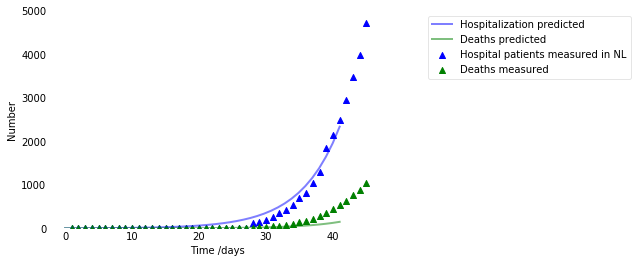

In [163]:
#t = np.linspace(1, I_measured_NL.size,I_measured_NL.size)
t1 = np.linspace(1, 45,45)
t2 = np.linspace(0, 41,41)
t3 = np.linspace(32,100,68)
t4 = np.linspace(39,100,62)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
#three sets of two plots
#ax.plot(t, I_measured_NL, 'y', alpha=0.5, lw=2, label='Infected patients measured in NL')
#ax.plot(t, E[0:27]+I_A[0:27]+I_S[0:27]+H_R[0:27]+H_IC[0:27], 'r', alpha=0.5, lw=2, label='Predicted infected people in NL')

ax.scatter(t1, H_measured_NL, color ='blue', marker = "^",label='Hospital patients measured in NL')
ax.plot(t2, H_R1[0:41]+H_IC1[0:41], 'blue', alpha=0.5, lw=2, label='Hospitalization predicted')
#ax.plot(t3, H_R2[1:69]+H_IC2[1:69], 'blue', alpha=0.5, lw=2, label='Hospitalization predicted')
#ax.plot(t4, H_R3[0:62]+H_IC3[0:62], 'blue', alpha=0.5, lw=2, label='Hospitalization predicted')
#ax.scatter(t1, IC_measured_NL, color = 'purple',marker = "^", label='IC patients measured in NL')
#ax.plot(t2, H_IC1[0:31], 'purple', alpha=0.5, lw=2, label='IC capacity predicted')

ax.scatter(t1, D_measured_NL, color ='green', marker = "^",label='Deaths measured')
ax.plot(t2, R_D1[0:41], 'green', alpha=0.5, lw=2, label='Deaths predicted')
#ax.plot(t3, R_D2[1:69], 'green', alpha=0.5, lw=2, label='Deaths predicted')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,5000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
leg = ax.legend()
leg.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
#a trick to get the legend in the right place
plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.75
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)


# Update the plot
plt.show()

R = 1 + λv + f(1 – f)(λv)2, where λ = ln[Y(t)]/t is the exponential growth rate of the epidemic, calculated as the logarithm of the cumulative number of cases by time t since the first case divided by the time required to generate these cases from a single case; v is the serial interval; and f is the ratio of the mean latent period, i.e., time from infection to onset of infectiousness, to the serial interval.

In [1371]:
t = range(I_measured_NL[13:].size)

In [1372]:
growth_rate = np.log(1/0.1*I_measured_NL[13:])/t

/Users/arnout.vos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [1373]:
f = a/(a + gamma3)
nu = a + gamma3

In [1374]:
R = 1 + growth_rate * nu + f * (1-f) * (growth_rate * nu)**2

/Users/arnout.vos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in add
  """Entry point for launching an IPython kernel.


In [1375]:
R

array([       nan, 4.05649799, 2.50914912, 2.0147304 , 1.77038324,
       1.67726187, 1.59722384, 1.53295862, 1.48372899, 1.43531016,
       1.39724837, 1.37129789, 1.34662817, 1.32875468, 1.31032036,
       1.29409616, 1.28125302, 1.26939805, 1.25860129, 1.24897959,
       1.2407106 , 1.23316954, 1.22530316, 1.21762057, 1.2113234 ,
       1.20525151, 1.19975151, 1.19465141, 1.18957994, 1.18454872,
       1.1793998 , 1.17445766])